# **AP Civic Atlas: Literacy & Healthcare Simulation Tool**

In [79]:
!pip install geopandas shapely folium prophet shap shapefile pyproj

ERROR: Could not find a version that satisfies the requirement shapefile (from versions: none)
ERROR: No matching distribution found for shapefile


In [80]:
import geopandas as gpd
import pandas as pd
import folium
from prophet import Prophet
import shap
import numpy as np
from ipywidgets import interact, FloatSlider

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')


<Axes: >

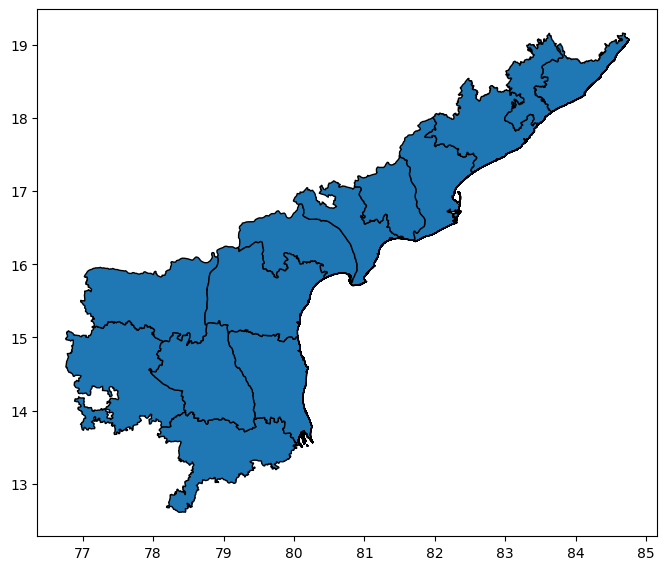

In [81]:
import geopandas as gpd

gdf = gpd.read_file("/content/gadm41_IND_2.shp")

ap_districts = gdf[gdf['NAME_1'] == 'Andhra Pradesh']

print(ap_districts.columns)

ap_districts.plot(edgecolor='black', figsize=(8,8))

In [82]:
print(gdf)

           GID_2 GID_0 COUNTRY     GID_1               NAME_1 NL_NAME_1  \
0      IND.1.1_1   IND   India   IND.1_1  Andaman and Nicobar        NA   
1      IND.1.2_1   IND   India   IND.1_1  Andaman and Nicobar        NA   
2      IND.1.3_1   IND   India   IND.1_1  Andaman and Nicobar        NA   
3      IND.2.1_1   IND   India   IND.2_1       Andhra Pradesh        NA   
4      IND.2.2_1   IND   India   IND.2_1       Andhra Pradesh        NA   
..           ...   ...     ...       ...                  ...       ...   
671  IND.36.16_1   IND   India  IND.36_1          West Bengal        NA   
672  IND.36.17_1   IND   India  IND.36_1          West Bengal        NA   
673  IND.36.18_1   IND   India  IND.36_1          West Bengal        NA   
674  IND.36.19_1   IND   India  IND.36_1          West Bengal        NA   
675  IND.36.20_1   IND   India  IND.36_1          West Bengal        NA   

                       NAME_2             VARNAME_2 NL_NAME_2    TYPE_2  \
0             Nicobar Is

In [83]:
import pandas as pd
df = pd.read_csv('/content/ap_population_literacy.csv')

In [84]:
print(df)

                              S.No.                District Name  Population  \
0                                 1                West Godavari   3936966.0   
1                                 2                      Krishna   4517398.0   
2                                 3                     Chittoor   4174064.0   
3                                 4                East Godavari   5154296.0   
4                                 5  Sri Potti Sriramulu Nellore   2963557.0   
5                                 6                       Guntur   4887813.0   
6                                 7                Visakhapatnam   4290589.0   
7                                 8                    Anantapur   4081148.0   
8                                 9                     Prakasam   3397448.0   
9                                10                   Srikakulam   2703114.0   
10                               11                      Kurnool   4053463.0   
11                               12     

In [85]:
print(df.columns.tolist())

['S.No.', 'District Name', 'Population', 'Literates', 'Literacy']


In [86]:
import geopandas as gpd
import pandas as pd
import numpy as np

# File paths
shapefile_path = "/content/gadm41_IND_2.shp"
csv_path       = "/content/ap_population_literacy.csv"
phc_path       = "/content/ap_phc_counts.csv"  # <-- Add your PHC CSV here

# Load shapefile and literacy data
gdf = gpd.read_file(shapefile_path)
df  = pd.read_csv(csv_path)
phc_df = pd.read_csv(phc_path)

# Filter for Andhra Pradesh
gdf = gdf[gdf['NAME_1'].str.strip().str.title() == "Andhra Pradesh"]

# Column names
shape_name_col = "NAME_2"
csv_name_col   = "District Name"

# Clean district names
def clean_name(s):
    return (
        s.str.strip()
         .str.replace(r"\s+", " ", regex=True)
         .str.title()
    )

gdf[shape_name_col] = clean_name(gdf[shape_name_col])
df[csv_name_col]    = clean_name(df[csv_name_col])
phc_df[csv_name_col] = clean_name(phc_df[csv_name_col])

# Apply name corrections
name_map = {
    "S.P.S. Nellore": "Sri Potti Sriramulu Nellore",
    "Sri P.S. Nellore": "Sri Potti Sriramulu Nellore",
    "Vizag": "Visakhapatnam",
    "East Godavari District": "East Godavari",
    "West Godavari District": "West Godavari",
    "Chitoor": "Chittoor",
    "Anantpur": "Anantapur",
    "Ananthapur": "Anantapur",
    "Vizianagram": "Vizianagaram"
}

gdf[shape_name_col] = gdf[shape_name_col].replace(name_map)
df[csv_name_col]    = df[csv_name_col].replace(name_map)
phc_df[csv_name_col] = phc_df[csv_name_col].replace(name_map)

merged = gdf.merge(
    df,
    left_on=shape_name_col,
    right_on=csv_name_col,
    how="inner"
)

merged = merged.merge(
    phc_df,
    on=csv_name_col,
    how="left"
)

merged["Population"] = (
    merged["Population"]
    .astype(str)
    .str.replace(",", "")
    .str.strip()
    .astype(float)
)

merged["Literacy"] = (
    merged["Literacy"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .str.strip()
    .astype(float)
)

def simulate_healthcare_access(row):
    literacy = row["Literacy"]
    phcs = row["PHC_Count"]
    population = row["Population"]

    if pd.isna(phcs) or population == 0:
        return np.nan

    literacy_factor = literacy / 100
    phc_density = (phcs / population) * 1000

    access_score = phc_density * 50 + literacy_factor * 50
    return round(access_score, 2)

merged["Simulated_Access_Score"] = merged.apply(simulate_healthcare_access, axis=1)

# Save GeoJSON
merged.to_file("ap_districts_with_simulation.geojson", driver="GeoJSON")

# Debug: confirm full match
print(f"Merged districts: {len(merged)}")
print("Unmatched shapefile districts:",
      set(gdf[shape_name_col]) - set(df[csv_name_col]))
print("Unmatched CSV districts:",
      set(df[csv_name_col]) - set(gdf[shape_name_col]))

print(merged[[csv_name_col, "Literacy", "PHC_Count", "Simulated_Access_Score"]])


Merged districts: 11
Unmatched shapefile districts: {'Y.S.R.', 'Nellore'}
Unmatched CSV districts: {nan, 'Sri Potti Sriramulu Nellore'}
    District Name  Literacy  PHC_Count  Simulated_Access_Score
0       Anantapur     63.57         25                   32.09
1        Chittoor     71.53         45                   36.30
2   East Godavari     70.99         92                   36.39
3          Guntur     67.40         82                   34.54
4         Krishna     73.74         16                   37.05
5         Kurnool     59.97         59                   30.71
6        Prakasam     63.08         58                   32.39
7      Srikakulam     61.74         42                   31.65
8   Visakhapatnam     66.91         41                   33.93
9    Vizianagaram     58.89         38                   30.26
10  West Godavari     74.63         37                   37.78


In [87]:
print(merged[["District Name", "Literacy", "Population", "PHC_Count"]].dtypes)


District Name     object
Literacy         float64
Population       float64
PHC_Count          int64
dtype: object


In [88]:
import folium
import geopandas as gpd

geojson_path = "ap_districts_with_simulation.geojson"
gdf = gpd.read_file(geojson_path)

gdf["Literacy"] = gdf["Literacy"].astype(float)
gdf["Simulated_Access_Score"] = gdf["Simulated_Access_Score"].astype(float)

m = folium.Map(location=[15.9, 79.7], zoom_start=7, tiles="CartoDB positron")

folium.Choropleth(
    geo_data=gdf,
    name="Simulated Healthcare Access",
    data=gdf,
    columns=["District Name", "Simulated_Access_Score"],
    key_on="feature.properties.District Name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name="Simulated Healthcare Access Score",
    nan_fill_color="lightgrey"
).add_to(m)

folium.GeoJson(
    gdf,
    name="District Info",
    tooltip=folium.GeoJsonTooltip(
        fields=["District Name", "Literacy", "PHC_Count", "Population", "Simulated_Access_Score"],
        aliases=["District:", "Literacy Rate (%):", "PHCs:", "Population:", "Access Score:"],
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)

m.save("ap_civic_impact_simulator.html")
print("Simulator map created: ap_civic_impact_simulator.html")


Simulator map created: ap_civic_impact_simulator.html
